In [2]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, mannwhitneyu
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
t = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

In [3]:
responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids))
non_responder = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids))
responder_screen = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.screen_ids))
non_responder_screen = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.screen_ids))
responder_day0 = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.day0_ids))
non_responder_day0 = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.day0_ids))
responder_adj_wk1 = hc_data.get_raw_features(hc_data.get_subset(hc_data.responder_ids, hc_data.adjwk1_ids))
non_responder_adk_wk1 = hc_data.get_raw_features(hc_data.get_subset(hc_data.non_responder_ids, hc_data.adjwk1_ids))

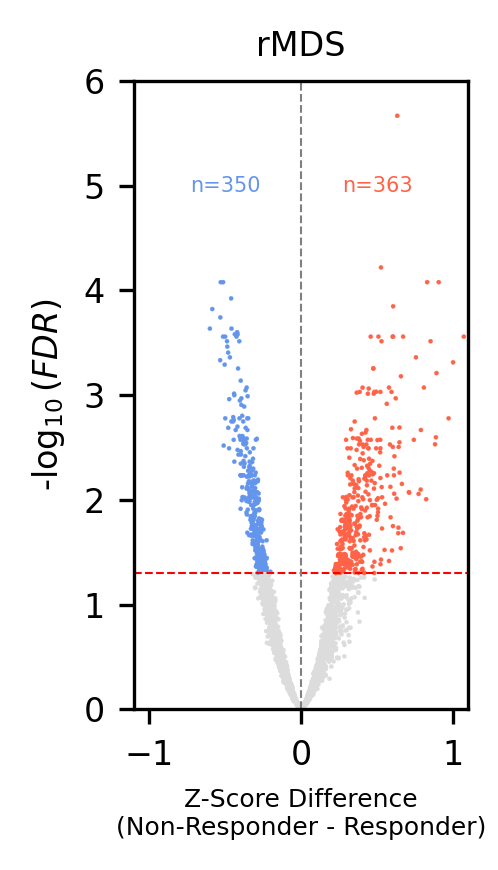

In [4]:
def create_volcano_plot(responder, nonresponder, ax, title, threshold=0.05):
    if set(responder.columns) != set(nonresponder.columns):
        raise ValueError("The columns are not the same between responder and nonresponder.")
    cols = responder.columns
    fold_changes = np.mean(nonresponder, axis=0) - np.mean(responder, axis=0)
    responder = responder.to_numpy()
    nonresponder = nonresponder.to_numpy()
    og_p_values = np.array([
        f_oneway(responder[:, i], nonresponder[:, i]).pvalue
        for i in range(responder.shape[1])
    ])
    _, og_p_values, _, _ = multipletests(og_p_values, alpha=threshold, method='fdr_bh')
    volcano_df = pd.DataFrame({
        'FoldChange': fold_changes,
        'PValue': og_p_values
    })
    volcano_df.index=cols
    volcano_df['NegLog10PValue'] = -np.log10(volcano_df['PValue'])
    threshold_log = -np.log10(threshold)
    volcano_df['Color'] = 'gainsboro' 
    volcano_df.loc[
        (abs(volcano_df['FoldChange']) > 0) & (volcano_df['NegLog10PValue'] > threshold_log), 
        'Color'
    ] = volcano_df.apply(
        lambda row: 'cornflowerblue' if row['FoldChange'] < 0 else 'tomato',
        axis=1
    )
    sns.scatterplot(data=volcano_df, x='FoldChange', y='NegLog10PValue', hue='Color', palette={'cornflowerblue': 'cornflowerblue', 'tomato': 'tomato', 'gainsboro': 'gainsboro'},
                    edgecolor=None, s=1, ax=ax)
    ax.axhline(threshold_log, color='red', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    if title == "rMDS":
        ax.set_xlabel('Z-Score Difference\n(Non-Responder - Responder)', fontsize=6)
    else:
        ax.set_xlabel(None)
    ax.set_ylabel(r'-$\log_{10}(FDR)$', fontsize=8)
    ax.set_title(title, fontsize=8)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(0, 6)
    ax.legend().remove()
    ax.tick_params(axis='both', labelsize=8)
    significant_indices = volcano_df.index[
        (volcano_df['NegLog10PValue'] > threshold_log)
    ].tolist()
    n_up = volcano_df[
        (volcano_df['NegLog10PValue'] > threshold_log) & 
        (volcano_df['FoldChange'] > 0)
    ].shape[0]
    
    n_down = volcano_df[
        (volcano_df['NegLog10PValue'] > threshold_log) & 
        (volcano_df['FoldChange'] < 0)
    ].shape[0]

    ax.text(0.5, 5, f"n={n_up}", color='tomato', fontsize=5, ha='center', va='center')
    ax.text(-0.5, 5, f"n={n_down}", color='cornflowerblue', fontsize=5, ha='center', va='center')
    return significant_indices
fig, axes = plt.subplots(1, 1, figsize=(1.76, 3.0), dpi=300)
significant_indices = create_volcano_plot(responder, non_responder, axes, 'rMDS')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0, hspace=0)

def save_as_bed(indices, filename):
    with open(filename, 'w') as f:
        for region in indices:
            chrom, positions = region.split(':')
            start, end = positions.split('-')
            f.write(f"{chrom}\t{start}\t{end}\n")

save_as_bed(significant_indices, 'F2C.Differential_rMDS.bed')
plt.tight_layout()
plt.savefig('F2C.rMDS.v1.pdf', dpi=1000)